### Preprocessing data

##### Copyright 2019 Google LLC

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

On data 
*Terrorists are linked to each other if they contact each other, use the same facility, are members of the same family, or belong to the same terrorist organization.*

# Graph regularization for document classification using natural graphs

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_mlp_cora"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/neural-structured-learning/blob/master/g3doc/tutorials/graph_keras_mlp_cora.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/neural-structured-learning/blob/master/g3doc/tutorials/graph_keras_mlp_cora.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

Graph regularization is a specific technique under the broader paradigm of
Neural Graph Learning
([Bui et al., 2018](https://ai.google/research/pubs/pub46568.pdf)). The core
idea is to train neural network models with a graph-regularized objective,
harnessing both labeled and unlabeled data.

In this tutorial, we will explore the use of graph regularization to classify
documents that form a natural (organic) graph.

The general recipe for creating a graph-regularized model using the Neural
Structured Learning (NSL) framework is as follows:

1.  Generate training data from the input graph and sample features. Nodes in
    the graph correspond to samples and edges in the graph correspond to
    similarity between pairs of samples. The resulting training data will
    contain neighbor features in addition to the original node features.
2.  Create a neural network as a base model using the `Keras` sequential,
    functional, or subclass API.
3.  Wrap the base model with the **`GraphRegularization`** wrapper class, which
    is provided by the NSL framework, to create a new graph `Keras` model. This
    new model will include a graph regularization loss as the regularization
    term in its training objective.
4.  Train and evaluate the graph `Keras` model.

## Overview

Graph regularization is a specific technique under the broader paradigm of
Neural Graph Learning
([Bui et al., 2018](https://ai.google/research/pubs/pub46568.pdf)). The core
idea is to train neural network models with a graph-regularized objective,
harnessing both labeled and unlabeled data.

We will explore the use of graph regularization to classify relationships between terrorists,
that form a natural (organic) graph.

The general recipe for creating a graph-regularized model using the Neural
Structured Learning (NSL) framework is as follows:

1.  Generate training data from the input graph and sample features. Nodes in
    the graph correspond to samples and edges in the graph correspond to
    similarity between pairs of samples. The resulting training data will
    contain neighbor features in addition to the original node features.
2.  Create a neural network as a base model using the `Keras` sequential,
    functional, or subclass API.
3.  Wrap the base model with the **`GraphRegularization`** wrapper class, which
    is provided by the NSL framework, to create a new graph `Keras` model. This
    new model will include a graph regularization loss as the regularization
    term in its training objective.
4.  Train and evaluate the graph `Keras` model.

## Setup



1.  Select TensorFlow 2.x to create an interactive development environment with eager execution.
2.  Install the Neural Structured Learning package.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  !pip install tensorflow-gpu>=2.0.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


In [3]:
!pip install --quiet neural-structured-learning

## Dependencies and imports

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import neural_structured_learning as nsl

import tensorflow as tf

## Cora dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/data) is a citation graph where
nodes represent machine learning papers and edges represent citations between
pairs of papers. The task involved is document classification where the goal is
to categorize each paper into one of 7 categories. In other words, this is a
multi-class classification problem with 7 classes.

### Graph

The original graph is directed. However, for the purpose of this example, we
consider the undirected version of this graph. So, if paper A cites paper B, we
also consider paper B to have cited A. Although this is not necessarily true, in
this example, we consider citations as a proxy for similarity, which is usually
a commutative property.

### Features

Each paper in the input effectively contains 2 features:

1.  **Words**: A dense, multi-hot bag-of-words representation of the text in the
    paper. The vocabulary for the Cora dataset contains 1433 unique words. So,
    the length of this feature is 1433, and the value at position 'i' is 0/1
    indicating whether word 'i' in the vocabulary exists in the given paper or
    not.

2.  **Label**: A single integer representing the class ID (category) of the paper.

### Download the Cora dataset

In [5]:
# !wget --quiet -P /tmp https://linqs-data.soe.ucsc.edu/public/lbc/TerroristRel.tgz 
# !wget --quiet -P /tmp https://github.com/mrweissguy/nsl/tree/master/data/TerroristRel
       
# !tar -C /tmp -xvzf /tmp/cora.tgz
# !tar -C /tmp -xvzf /tmp/TerroristRel.tgz
!tar -C /tmp -xvzf /Users/johanweisshansen/Desktop/nsl-master/dataset_test_1/data/CustomTerroristRel.tgz

x CustomTerroristRel/
x CustomTerroristRel/TerroristRel_Family.nodes
x CustomTerroristRel/TerroristRel_Colleague.nodes
x CustomTerroristRel/TerroristRel_Contact.nodes
x CustomTerroristRel/.DS_Store
x CustomTerroristRel/collected.nodes
x CustomTerroristRel/README
x CustomTerroristRel/TerroristRel.labels
x CustomTerroristRel/TerroristRel_Congregate.nodes
x CustomTerroristRel/TerroristRel.edges


### Convert the Cora data to the NSL format

In order to preprocess the Terrorist Relations dataset and convert it to the format required by
Neural Structured Learning, we will run the **'preprocess_cora_dataset.py'**
script, which is included in the NSL github repository. This script does the
following:

1.  Generate neighbor features using the original node features and the graph.
2.  Generate train and test data splits containing `tf.train.Example` instances.
3.  Persist the resulting train and test data in the `TFRecord` format.

In [6]:
# !wget https://raw.githubusercontent.com/tensorflow/neural-structured-learning/master/neural_structured_learning/examples/preprocess/cora/preprocess_cora_dataset.py

# !python preprocess_cora_dataset.py \
# --input_cora_content=/tmp/cora/cora.content \
# --input_cora_graph=/tmp/cora/cora.cites \
# --max_nbrs=5 \
# --output_train_data=/tmp/cora/train_merged_examples.tfr \
# --output_test_data=/tmp/cora/test_examples.tfr

# !wget https://raw.githubusercontent.com/mrweissguy/nsl/master/preprocessing_terror_dataset.py?token=AKMVMPGQOLZCWR6HB2NCZQK5XGN6U
# https://raw.githubusercontent.com/mrweissguy/nsl/master/preprocessing_terror_dataset.py?token=AKMVMPEPFXMPBD5SDWZSSOS5XF6NO
# !wget https://raw.githubusercontent.com/mrweissguy/nsl/master/dataset_test_1/preprocessing_terror_dataset.py?token=AKMVMPBECTX7YBDS2EH3I5K5ZPDUE
  
!python preprocessing_terror_dataset.py \
--input_cora_content=/tmp/CustomTerroristRel/collected.nodes \
--input_cora_graph=/tmp/CustomTerroristRel/TerroristRel.edges \
--max_nbrs=3 \
--output_train_data=/tmp/CustomTerroristRel/train_merged_examples.tfr \
--output_test_data=/tmp/CustomTerroristRel/test_examples.tfr


preprocessing_terror_dataset.py:138: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as cora_content:
Reading graph file: /tmp/CustomTerroristRel/TerroristRel.edges...
Done reading 8592 edges from: /tmp/CustomTerroristRel/TerroristRel.edges (0.01 seconds).
Making all edges bi-directional...
Done (0.01 seconds). Total graph nodes: 881
Joining seed and neighbor tf.train.Examples with graph edges...
W1127 10:55:49.359920 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/29#MohammedSchreim_http://profilesinterror.mindswap.org/document/29#NasserWatimi"
W1127 10:55:49.361066 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/2005/08/09/16:36:24#_http://profilesinterror.mindswap.org/document/2005/08/09/16:43:04#"
W1127 10:55:49.361141 4522884544 preprocessing_terror_dataset.py:191] No tf.train

W1127 10:55:49.423077 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://counterterror.mindswap.org/2005/terrorists.owl#Richard_Colvin_Reid_http://profilesinterror.mindswap.org/document/2005/09/07/09:36:59#"
W1127 10:55:49.423145 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/2005/08/09/16:36:24#_http://profilesinterror.mindswap.org/document/2005/08/09/16:43:04#"
W1127 10:55:49.423194 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://counterterror.mindswap.org/2005/terrorists.owl#Nizar_Trabelsi_http://profilesinterror.mindswap.org/document/2005/09/07/09:36:59#"
W1127 10:55:49.424400 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://counterterror.mindswap.org/2005/terrorists.owl#Richard_Colvin_Reid_http://profilesinterror.mindswap.org/documen

W1127 10:55:49.478043 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/2005/12/22/19:57:48#_http://counterterror.mindswap.org/2005/terrorists.owl#Lionel_Dumont"
W1127 10:55:49.479056 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/19#MohammedSalameh_http://profilesinterror.mindswap.org/document/19#EyadIsmoil"
W1127 10:55:49.479128 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/19#EyadIsmoil_http://profilesinterror.mindswap.org/document/19#Nidal_Ayyad"
W1127 10:55:49.479176 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/19#EyadIsmoil_http://profilesinterror.mindswap.org/document/4#Ramzi_Yousef"
W1127 10:55:49.479722 4522

W1127 10:55:49.586144 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/19#MohammedSalameh_http://profilesinterror.mindswap.org/document/19#Nidal_Ayyad"
W1127 10:55:49.586374 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/19#MohammedSalameh_http://profilesinterror.mindswap.org/document/19#EyadIsmoil"
W1127 10:55:49.586480 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/19#MohammedSalameh_http://profilesinterror.mindswap.org/document/4#Ramzi_Yousef"
W1127 10:55:49.586569 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/19#MohammedSalameh_http://profilesinterror.mindswap.org/document/19#AhmadAjaj"
W1127 10:55:49.598551 45228

W1127 10:55:49.678184 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://counterterror.mindswap.org/2005/terrorists.owl#Nizar_Trabelsi_http://counterterror.mindswap.org/2005/terrorists.owl#Richard_Colvin_Reid"
W1127 10:55:49.678241 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://counterterror.mindswap.org/2005/terrorists.owl#Djamel_Beghal_http://counterterror.mindswap.org/2005/terrorists.owl#Nizar_Trabelsi"
W1127 10:55:49.679452 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/29#FathiKhatib_http://profilesinterror.mindswap.org/document/29#MuammarSheikh"
W1127 10:55:49.682338 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/2005/12/22/19:57:48#_http://counterterror.mindswap.org/2005/terrorists.owl#Lion

W1127 10:55:49.731171 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/2006/03/17/05:42:48#_http://profilesinterror.mindswap.org/document/2006/03/15/04:58:21#"
W1127 10:55:49.731286 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/2006/03/15/22:21:03#_http://profilesinterror.mindswap.org/document/2006/03/15/04:58:21#"
W1127 10:55:49.731343 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/2006/03/17/05:47:04#_http://profilesinterror.mindswap.org/document/2006/03/15/04:58:21#"
W1127 10:55:49.732405 4522884544 preprocessing_terror_dataset.py:191] No tf.train.Example found for edge target ID: "http://profilesinterror.mindswap.org/document/29#FathiKhatib_http://profilesinterror.mindswap.org/document/29#MuammarSheikh"
W1

## Global variables

The file paths to the train and test data are based on the command line flag
values used to invoke the **'preprocess_cora_dataset.py'** script above.

In [7]:
# ### Experiment dataset
# TRAIN_DATA_PATH = '/tmp/cora/train_merged_examples.tfr'
# TEST_DATA_PATH = '/tmp/cora/test_examples.tfr'

# ### Constants used to identify neighbor features in the input.
# NBR_FEATURE_PREFIX = 'NL_nbr_'
# NBR_WEIGHT_SUFFIX = '_weight'

### Experiment dataset
TRAIN_DATA_PATH = '/tmp/CustomTerroristRel/train_merged_examples.tfr'
TEST_DATA_PATH = '/tmp/CustomTerroristRel/test_examples.tfr'

### Constants used to identify neighbor features in the input.
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

## Hyperparameters

We will use an instance of `HParams` to inclue various hyperparameters and
constants used for training and evaluation. We briefly describe each of them
below:

-   **num_classes**: There are a total 7 different classes

-   **max_seq_length**: This is the size of the vocabulary and all instances in
    the input have a dense multi-hot, bag-of-words representation. In other
    words, a value of 1 for a word indicates that the word is present in the
    input and a value of 0 indicates that it is not.

-   **distance_type**: This is the distance metric used to regularize the sample
    with its neighbors.

-   **graph_regularization_multiplier**: This controls the relative weight of
    the graph regularization term in the overall loss function.

-   **num_neighbors**: The number of neighbors used for graph regularization.
    This value has to be less than or equal to the `max_nbrs` command-line
    argument used above when running `preprocess_cora_dataset.py`.

-   **num_fc_units**: The number of fully connected layers in our neural
    network.

-   **train_epochs**: The number of training epochs.

-   **batch_size**: Batch size used for training and evaluation.

-   **dropout_rate**: Controls the rate of dropout following each fully
    connected layer

-   **eval_steps**: The number of batches to process before deeming evaluation
    is complete. If set to `None`, all instances in the test set are evaluated.

In [8]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 4
#     self.num_classes = 2
    self.max_seq_length = 1224 # distinct features
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.1
    self.num_neighbors = 1
    ### model architecture
    self.num_fc_units = [50,50]
    ### training parameters
    self.train_epochs = 150
    self.batch_size = 150
    self.dropout_rate = 0.5
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()

## Load train and test data

As described earlier in this notebook, the input training and test data have
been created by the **'preprocess_cora_dataset.py'**. We will load them into two
`tf.data.Dataset` objects -- one for train and one for test.

In the input layer of our model, we will extract not just the 'words' and the
'label' features from each sample, but also corresponding neighbor features
based on the `hparams.num_neighbors`. Instances with fewer neighbors than
`hparams.num_neighbors` will be assigned dummy values for those non-existent
neighbor features.

In [9]:
def parse_example(example_proto):
  """Extracts relevant fields from the `example_proto`.

  Args:
    example_proto: An instance of `tf.train.Example`.

  Returns:
    A pair whose first value is a dictionary containing relevant features
    and whose second value contains the ground truth labels.
  """
  # The 'words' feature is a multi-hot, bag-of-words representation of the
  # original raw text. A default value is required for examples that don't
  # have the feature.
  feature_spec = {
      'words':
          tf.io.FixedLenFeature([HPARAMS.max_seq_length],
                                tf.int64,
                                default_value=tf.constant(
                                    0,
                                    dtype=tf.int64,
                                    shape=[HPARAMS.max_seq_length])),
      'label':
          tf.io.FixedLenFeature((), tf.int64, default_value=-1),
  }
  # We also extract corresponding neighbor features in a similar manner to
  # the features above.
  for i in range(HPARAMS.num_neighbors):
    nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
    nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i, NBR_WEIGHT_SUFFIX)
    feature_spec[nbr_feature_key] = tf.io.FixedLenFeature(
        [HPARAMS.max_seq_length],
        tf.int64,
        default_value=tf.constant(
            0, dtype=tf.int64, shape=[HPARAMS.max_seq_length]))

    # We assign a default value of 0.0 for the neighbor weight so that
    # graph regularization is done on samples based on their exact number
    # of neighbors. In other words, non-existent neighbors are discounted.
    feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
        [1], tf.float32, default_value=tf.constant([0.0]))

  features = tf.io.parse_single_example(example_proto, feature_spec)

  labels = features.pop('label')
  return features, labels


def make_dataset(file_path, training=False):
  """Creates a `tf.data.TFRecordDataset`.

  Args:
    file_path: Name of the file in the `.tfrecord` format containing
      `tf.train.Example` objects.
    training: Boolean indicating if we are in training mode.

  Returns:
    An instance of `tf.data.TFRecordDataset` containing the `tf.train.Example`
    objects.
  """
  dataset = tf.data.TFRecordDataset([file_path])
  if training:
    dataset = dataset.shuffle(10000)
  dataset = dataset.map(parse_example)
  dataset = dataset.batch(HPARAMS.batch_size)
  return dataset


train_dataset = make_dataset(TRAIN_DATA_PATH, training=True)
test_dataset = make_dataset(TEST_DATA_PATH)

Let's peek into the train dataset to look at its contents.

In [10]:
for feature_batch, label_batch in train_dataset.take(1):
    print('Feature list:', list(feature_batch.keys()))
    print('Batch of inputs:', feature_batch['words'])
    nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, 0, 'words')
    nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, 0, NBR_WEIGHT_SUFFIX)
    print('Batch of neighbor inputs:', feature_batch[nbr_feature_key])
    print('Batch of neighbor weights:',
        tf.reshape(feature_batch[nbr_weight_key], [-1]))
    print('Batch of labels:', label_batch)

Feature list: ['NL_nbr_0_weight', 'NL_nbr_0_words', 'words']
Batch of inputs: tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]], shape=(150, 1224), dtype=int64)
Batch of neighbor inputs: tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]], shape=(150, 1224), dtype=int64)
Batch of neighbor weights: tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.], shape=(150,), dtype=float32)
Batch of labels: tf.Tensor(
[2 2 2 2 2 1 2

Let's peek into the test dataset to look at its contents.

In [11]:
for feature_batch, label_batch in test_dataset.take(1):
    print('Feature list:', list(feature_batch.keys()))
    print('Batch of inputs:', feature_batch['words'])
    nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, 0, 'words')
    nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, 0, NBR_WEIGHT_SUFFIX)
    print('Batch of neighbor inputs:', feature_batch[nbr_feature_key])
    print('Batch of neighbor weights:',
        tf.reshape(feature_batch[nbr_weight_key], [-1]))
    print('Batch of labels:', label_batch)

Feature list: ['NL_nbr_0_weight', 'NL_nbr_0_words', 'words']
Batch of inputs: tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(150, 1224), dtype=int64)
Batch of neighbor inputs: tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(150, 1224), dtype=int64)
Batch of neighbor weights: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], shape=(150,), dtype=float32)
Batch of labels: tf.Tensor(
[2 0 0 2 2 1 2

## Model definition

In order to demonstrate the use of graph regularization, we build a base model
for this problem first. We will use a simple feed-forward neural network with 2
hidden layers and dropout in between. We illustrate the creation of the base
model using all model types supported by the `tf.Keras` framework -- sequential,
functional, and subclass.

### Sequential base model

In [12]:
def make_mlp_sequential_model(hparams):
  """Creates a sequential multi-layer perceptron model."""
  model = tf.keras.Sequential()
  model.add(
      tf.keras.layers.InputLayer(
          input_shape=(hparams.max_seq_length,), name='words'))
  # Input is already one-hot encoded in the integer format. We cast it to
  # floating point format here.
  model.add(
      tf.keras.layers.Lambda(lambda x: tf.keras.backend.cast(x, tf.float32)))
  for num_units in hparams.num_fc_units:
    model.add(tf.keras.layers.Dense(num_units, activation='relu'))
    # For sequential models, by default, Keras ensures that the 'dropout' layer
    # is invoked only during training.
    model.add(tf.keras.layers.Dropout(hparams.dropout_rate))
  model.add(tf.keras.layers.Dense(hparams.num_classes, activation='softmax'))
  return model

### Functional base model

In [13]:
def make_mlp_functional_model(hparams):
    """Creates a functional API-based multi-layer perceptron model."""
    inputs = tf.keras.Input(shape=(hparams.max_seq_length,), dtype='int64', name='words')

  # Input is already one-hot encoded in the integer format. We cast it to
  # floating point format here.
    cur_layer = tf.keras.layers.Lambda(
      lambda x: tf.keras.backend.cast(x, tf.float32))(
          inputs)

    for num_units in hparams.num_fc_units:
        cur_layer = tf.keras.layers.Dense(num_units, activation='relu')(cur_layer)
        # For functional models, by default, Keras ensures that the 'dropout' layer
        # is invoked only during training.
        cur_layer = tf.keras.layers.Dropout(hparams.dropout_rate)(cur_layer)
        cur_layer = tf.keras.layers.BatchNormalization()(cur_layer)

    outputs = tf.keras.layers.Dense(
      hparams.num_classes, activation='softmax')(
          cur_layer)

    model = tf.keras.Model(inputs, outputs=outputs)
    return model

In [14]:
# inputs = tf.keras.Input(
#       shape=(1224,), dtype='int64', name='words')

# cur_layer = tf.keras.layers.Lambda(
#       lambda x: tf.keras.backend.cast(x, tf.float32))(
#           inputs)

# base_model = tf.keras.Sequential([
#         tf.keras.layers.Dense(10, input_dim=inputs, activation=tf.nn.relu)(cur_layer),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(rate=0.5),
#         tf.keras.layers.Dense(1, activation=tf.nn.softmax)
#     ])

### Subclass base model

In [15]:
def make_mlp_subclass_model(hparams):
  """Creates a multi-layer perceptron subclass model in Keras."""

  class MLP(tf.keras.Model):
    """Subclass model defining a multi-layer perceptron."""

    def __init__(self):
      super(MLP, self).__init__()
      # Input is already one-hot encoded in the integer format. We create a
      # layer to cast it to floating point format here.
      self.cast_to_float_layer = tf.keras.layers.Lambda(
          lambda x: tf.keras.backend.cast(x, tf.float32))
      self.dense_layers = [
          tf.keras.layers.Dense(num_units, activation='relu')
          for num_units in hparams.num_fc_units
      ]
      self.dropout_layer = tf.keras.layers.Dropout(hparams.dropout_rate)
      self.output_layer = tf.keras.layers.Dense(
          hparams.num_classes, activation='softmax')

    def call(self, inputs, training=False):
      cur_layer = self.cast_to_float_layer(inputs['words'])
      for dense_layer in self.dense_layers:
        cur_layer = dense_layer(cur_layer)
        cur_layer = self.dropout_layer(cur_layer, training=training)

      outputs = self.output_layer(cur_layer)

      return outputs

  return MLP()

## Create base model(s)

In [16]:
# Create a base MLP model using the functional API.
# Alternatively, you can also create a sequential or subclass base model using
# the make_mlp_sequential_model() or make_mlp_subclass_model() functions
# respectively, defined above. Note that if a subclass model is used, its
# summary cannot be generated until it is built.
base_model_tag, base_model = 'FUNCTIONAL', make_mlp_functional_model(HPARAMS)
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words (InputLayer)           [(None, 1224)]            0         
_________________________________________________________________
lambda (Lambda)              (None, 1224)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                61250     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

## Train base (Multilayer perceptron) MLP model

In [17]:
# Compile and train the base MLP model
base_model.compile(
    optimizer='adam',
    #sparse_categorical_crossentropy
    #categorical_crossentropy
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    lr=0.01, clipnorm=1.)
base_model_history = base_model.fit(train_dataset, epochs=HPARAMS.train_epochs, verbose=1, validation_data=test_dataset) 
# history = base_model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=1)
# history = base_model.fit(train_dataset, test_dataset, validation_split=0.33, epochs=50)

Epoch 1/150
5/5 [==============================] - 1s 223ms/step - loss: 1.8645 - accuracy: 0.3054 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/150
5/5 [==============================] - 0s 22ms/step - loss: 1.5874 - accuracy: 0.3907 - val_loss: 1.3005 - val_accuracy: 0.6284
Epoch 3/150
5/5 [==============================] - 0s 22ms/step - loss: 1.4199 - accuracy: 0.4386 - val_loss: 1.2579 - val_accuracy: 0.6557
Epoch 4/150
5/5 [==============================] - 0s 22ms/step - loss: 1.2442 - accuracy: 0.5075 - val_loss: 1.2210 - val_accuracy: 0.6393
Epoch 5/150
5/5 [==============================] - 0s 21ms/step - loss: 1.1664 - accuracy: 0.5165 - val_loss: 1.1901 - val_accuracy: 0.6339
Epoch 6/150
5/5 [==============================] - 0s 20ms/step - loss: 1.1302 - accuracy: 0.5419 - val_loss: 1.1652 - val_accuracy: 0.6284
Epoch 7/150
5/5 [==============================] - 0s 20ms/step - loss: 1.0272 - accuracy: 0.5838 - val_loss: 1.1435 - val_accuracy: 0.6339
Epoch 8/150

5/5 [==============================] - 0s 37ms/step - loss: 0.2076 - accuracy: 0.9296 - val_loss: 0.6389 - val_accuracy: 0.8142
Epoch 118/150
5/5 [==============================] - 0s 28ms/step - loss: 0.2215 - accuracy: 0.9162 - val_loss: 0.6530 - val_accuracy: 0.8142
Epoch 119/150
5/5 [==============================] - 0s 26ms/step - loss: 0.2162 - accuracy: 0.9192 - val_loss: 0.6623 - val_accuracy: 0.8197
Epoch 120/150
5/5 [==============================] - 0s 28ms/step - loss: 0.2035 - accuracy: 0.9162 - val_loss: 0.6565 - val_accuracy: 0.8142
Epoch 121/150
5/5 [==============================] - 0s 22ms/step - loss: 0.1990 - accuracy: 0.9222 - val_loss: 0.6514 - val_accuracy: 0.8087
Epoch 122/150
5/5 [==============================] - 0s 22ms/step - loss: 0.2510 - accuracy: 0.8982 - val_loss: 0.6449 - val_accuracy: 0.8251
Epoch 123/150
5/5 [==============================] - 0s 22ms/step - loss: 0.2171 - accuracy: 0.9192 - val_loss: 0.6416 - val_accuracy: 0.8251
Epoch 124/150
5/5 [=

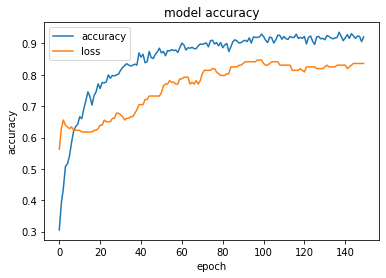

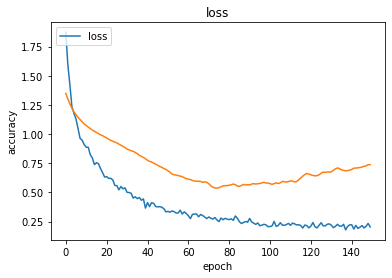

In [27]:
# base_model.history.history['accuracy']

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(base_model_history.history['accuracy'])
plt.plot(base_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(base_model.history.history['loss'])
plt.plot(base_model_history.history['val_loss'])
plt.title('loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

## Evaluate base MLP model

In [19]:
# Helper function to print evaluation metrics.
def print_metrics(model_desc, eval_metrics):
  """Prints evaluation metrics.

  Args:
    model_desc: A description of the model.
    eval_metrics: A dictionary mapping metric names to corresponding values. It
      must contain the loss and accuracy metrics.
  """
  print('\n')
  print('Eval accuracy for ', model_desc, ': ', eval_metrics['accuracy'])
  print('Eval loss for ', model_desc, ': ', eval_metrics['loss'])
  if 'graph_loss' in eval_metrics:
    print('Eval graph loss for ', model_desc, ': ', eval_metrics['graph_loss'])

In [20]:
eval_results = dict(
    zip(base_model.metrics_names,
        base_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)))
print_metrics('Base MLP model', eval_results)

2/2 [==============================] - 0s 14ms/step - loss: 0.7376 - accuracy: 0.8361


Eval accuracy for  Base MLP model :  0.8360656
Eval loss for  Base MLP model :  0.7376169115304947


## Train MLP model with graph regularization

Incorporating graph regularization into the loss term of an existing
`tf.Keras.Model` requires just a few lines of code. The base model is wrapped to
create a new `tf.Keras` subclass model, whose loss includes graph
regularization.

To assess the incremental benefit of graph regularization, we will create a new
base model instance. This is because `base_model` has already been trained for a
few iterations, and reusing this trained model to create a graph-regularized
model will not be a fair comparison for `base_model`.

In [21]:
# Build a new base MLP model.
base_reg_model_tag, base_reg_model = 'FUNCTIONAL', make_mlp_functional_model(
    HPARAMS)

In [22]:
# Wrap the base MLP model with graph regularization.
graph_reg_config = nsl.configs.make_graph_reg_config(
    max_neighbors=HPARAMS.num_neighbors,
    multiplier=HPARAMS.graph_regularization_multiplier,
    distance_type=HPARAMS.distance_type,
    sum_over_axis=-1)

graph_reg_model = nsl.keras.GraphRegularization(base_reg_model,
                                                graph_reg_config)
graph_reg_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
graph_reg_model_history = graph_reg_model.fit(train_dataset, epochs=HPARAMS.train_epochs, verbose=1, validation_data=test_dataset)

Epoch 1/150


/Users/johanweisshansen/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/johanweisshansen/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


5/5 [==============================] - 4s 757ms/step - loss: 1.8225 - accuracy: 0.2710 - graph_loss: 0.2986 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_graph_loss: 0.0000e+00
Epoch 2/150
5/5 [==============================] - 0s 24ms/step - loss: 1.6438 - accuracy: 0.2964 - graph_loss: 0.2886 - val_loss: 1.3205 - val_accuracy: 0.5191 - val_graph_loss: 0.0000e+00
Epoch 3/150
5/5 [==============================] - 0s 27ms/step - loss: 1.4386 - accuracy: 0.4117 - graph_loss: 0.2752 - val_loss: 1.2916 - val_accuracy: 0.5847 - val_graph_loss: 0.0000e+00
Epoch 4/150
5/5 [==============================] - 0s 28ms/step - loss: 1.4196 - accuracy: 0.4117 - graph_loss: 0.2534 - val_loss: 1.2635 - val_accuracy: 0.6612 - val_graph_loss: 0.0000e+00
Epoch 5/150
5/5 [==============================] - 0s 24ms/step - loss: 1.3572 - accuracy: 0.4446 - graph_loss: 0.2686 - val_loss: 1.2353 - val_accuracy: 0.6885 - val_graph_loss: 0.0000e+00
Epoch 6/150
5/5 [==============================] - 0s

Epoch 44/150
5/5 [==============================] - 0s 25ms/step - loss: 0.3903 - accuracy: 0.8713 - graph_loss: 0.2201 - val_loss: 0.5222 - val_accuracy: 0.8142 - val_graph_loss: 0.0000e+00
Epoch 45/150
5/5 [==============================] - 0s 24ms/step - loss: 0.4016 - accuracy: 0.8698 - graph_loss: 0.2006 - val_loss: 0.5215 - val_accuracy: 0.8142 - val_graph_loss: 0.0000e+00
Epoch 46/150
5/5 [==============================] - 0s 24ms/step - loss: 0.4188 - accuracy: 0.8548 - graph_loss: 0.2296 - val_loss: 0.5187 - val_accuracy: 0.8197 - val_graph_loss: 0.0000e+00
Epoch 47/150
5/5 [==============================] - 0s 24ms/step - loss: 0.3946 - accuracy: 0.8802 - graph_loss: 0.2321 - val_loss: 0.5160 - val_accuracy: 0.8306 - val_graph_loss: 0.0000e+00
Epoch 48/150
5/5 [==============================] - 0s 24ms/step - loss: 0.3843 - accuracy: 0.8728 - graph_loss: 0.2330 - val_loss: 0.5110 - val_accuracy: 0.8306 - val_graph_loss: 0.0000e+00
Epoch 49/150
5/5 [===========================

Epoch 87/150
5/5 [==============================] - 0s 22ms/step - loss: 0.2749 - accuracy: 0.9057 - graph_loss: 0.2379 - val_loss: 0.5821 - val_accuracy: 0.8470 - val_graph_loss: 0.0000e+00
Epoch 88/150
5/5 [==============================] - 0s 23ms/step - loss: 0.2913 - accuracy: 0.8982 - graph_loss: 0.2460 - val_loss: 0.5841 - val_accuracy: 0.8525 - val_graph_loss: 0.0000e+00
Epoch 89/150
5/5 [==============================] - 0s 24ms/step - loss: 0.2867 - accuracy: 0.9087 - graph_loss: 0.2539 - val_loss: 0.5803 - val_accuracy: 0.8525 - val_graph_loss: 0.0000e+00
Epoch 90/150
5/5 [==============================] - 0s 22ms/step - loss: 0.2690 - accuracy: 0.9042 - graph_loss: 0.2317 - val_loss: 0.5711 - val_accuracy: 0.8579 - val_graph_loss: 0.0000e+00
Epoch 91/150
5/5 [==============================] - 0s 23ms/step - loss: 0.2677 - accuracy: 0.9147 - graph_loss: 0.2732 - val_loss: 0.5742 - val_accuracy: 0.8579 - val_graph_loss: 0.0000e+00
Epoch 92/150
5/5 [===========================

Epoch 130/150
5/5 [==============================] - 0s 25ms/step - loss: 0.2479 - accuracy: 0.9341 - graph_loss: 0.2624 - val_loss: 0.6302 - val_accuracy: 0.8579 - val_graph_loss: 0.0000e+00
Epoch 131/150
5/5 [==============================] - 0s 35ms/step - loss: 0.2211 - accuracy: 0.9237 - graph_loss: 0.2397 - val_loss: 0.6325 - val_accuracy: 0.8579 - val_graph_loss: 0.0000e+00
Epoch 132/150
5/5 [==============================] - 0s 31ms/step - loss: 0.2452 - accuracy: 0.9162 - graph_loss: 0.2815 - val_loss: 0.6400 - val_accuracy: 0.8579 - val_graph_loss: 0.0000e+00
Epoch 133/150
5/5 [==============================] - 0s 24ms/step - loss: 0.2435 - accuracy: 0.8967 - graph_loss: 0.2746 - val_loss: 0.6418 - val_accuracy: 0.8579 - val_graph_loss: 0.0000e+00
Epoch 134/150
5/5 [==============================] - 0s 25ms/step - loss: 0.2556 - accuracy: 0.9281 - graph_loss: 0.2934 - val_loss: 0.6407 - val_accuracy: 0.8634 - val_graph_loss: 0.0000e+00
Epoch 135/150
5/5 [=====================

In [23]:
graph_reg_model.history.history.keys()

dict_keys(['loss', 'accuracy', 'graph_loss', 'val_loss', 'val_accuracy', 'val_graph_loss'])

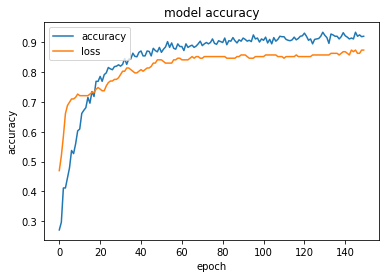

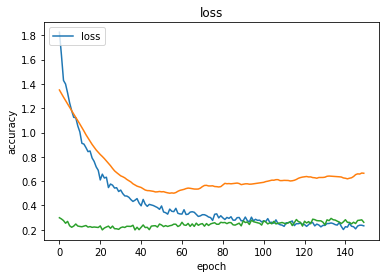

In [24]:
# base_model.history.history['accuracy']

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(graph_reg_model_history.history['accuracy'])
plt.plot(graph_reg_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(graph_reg_model.history.history['loss'])
plt.plot(graph_reg_model.history.history['val_loss'])
plt.plot(graph_reg_model.history.history['graph_loss'])
plt.title('loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

## Evaluate MLP model with graph regularization

In [25]:
eval_results = dict(
    zip(graph_reg_model.metrics_names,
        graph_reg_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)))
print_metrics('MLP + graph regularization', eval_results)

2/2 [==============================] - 0s 12ms/step - loss: 0.6648 - accuracy: 0.8743 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.87431693
Eval loss for  MLP + graph regularization :  0.6648462563753128
Eval graph loss for  MLP + graph regularization :  0.0


The graph-regularized model's accuracy is about 2-3% higher than that of the
base model (`base_model`).

## Conclusion

We have demonstrated the use of graph regularization for document classification
on a natural citation graph (Cora) using the Neural Structured Learning (NSL)
framework. Our [advanced tutorial](graph_keras_lstm_imdb.ipynb) involves
synthesizing graphs based on sample embeddings before training a neural network
with graph regularization. This approach is useful if the input does not contain
an explicit graph.

We encourage users to experiment further by varying the amount of supervision as
well as trying different neural architectures for graph regularization.

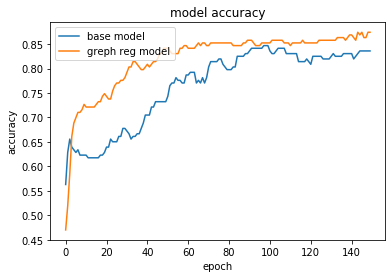

In [30]:
# base_model.history.history['accuracy']

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(base_model_history.history['val_accuracy'])
plt.plot(graph_reg_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['base model', 'greph reg model'], loc='upper left')
plt.show()

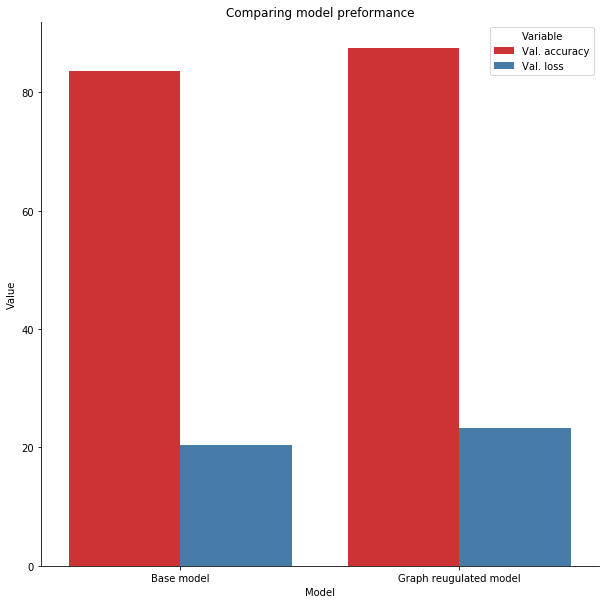

In [38]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({
    'Model': ['Base model', 'Graph reugulated model'],
    'Val. accuracy': [base_model_history.history['val_accuracy'][-1]*100, graph_reg_model_history.history['val_accuracy'][-1]*100],
    'Val. loss': [base_model_history.history['loss'][-1]*100, graph_reg_model_history.history['loss'][-1]*100]
    })
fig, ax1 = plt.subplots(figsize=(10, 10))
plt.title("Comparing model preformance")
tidy = df.melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy, ax=ax1,  palette="Set1")
sns.despine(fig)

0.87431693